# Prophet on telemetry dataset

https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.prophet.html

laptime&rank dataset
<eventid, carids, ts[carid][second_seqid, vspeed, distance])>; filled with NaN

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
### test on one run
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.model.prophet import ProphetPredictor

#
# remove NaN at the tail
#
def make_dataset(prediction_length, freq, run_ts=2):
    start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

    train_set = []
    test_set = []
    #_data: eventid, carids, laptime array
    for _data in telemetry_data:
        _train = []
        _test = []
        for rowid in range(len(_data[2])):
            rec = _data[2][rowid]
            
            if (len(rec) < prediction_length):
                print('a short ts: carid=', _data[1][rowid])
                continue
            
            ##remove all nan
            #rec = rec[~np.isnan(rec)]
            # remove nan at tail
            idx = 1
            while idx < rec.shape[0]:
                if rec[-idx,0] == np.nan or rec[-idx,1] == np.nan or rec[-idx,2] == np.nan:
                    idx += 1
                    continue
                break
            if idx > 1:
                rec = rec[:-idx]
            
            _train.append({'target': rec[:-prediction_length,run_ts].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': global_carids[_data[1][rowid]]}
                          )
            _test.append({'target': rec[:,run_ts].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': global_carids[_data[1][rowid]]}
                          )    
            #add one ts
            print(f'carno:{_data[1][rowid]}, len:{len(rec)}')
            
        train_set.extend(_train)
        test_set.extend(_test)

    # train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
    train_ds = ListDataset(train_set, freq=freq)
    # test dataset: use the whole dataset, add "target" and "start" fields
    test_ds = ListDataset(test_set, freq=freq)    
    return train_ds, test_ds

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

#
# remove nan with interpolate
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
# https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
def make_dataset_interpolate(prediction_length, freq, run_ts=2):
    start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

    train_set = []
    test_set = []
    #_data: eventid, carids, laptime array
    for _data in telemetry_data:
        _train = []
        _test = []
        for rowid in range(len(_data[2])):
            rec = _data[2][rowid].copy()
            
            if (len(rec) < prediction_length):
                print('a short ts: carid=', _data[1][rowid])
                continue
            
            ##remove all nan
            #rec = rec[~np.isnan(rec)]
            # remove nan at tail
            idx = 1
            while idx < rec.shape[0]:
                if rec[-idx,0] == np.nan or rec[-idx,1] == np.nan or rec[-idx,2] == np.nan:
                    idx += 1
                    continue
                break
            if idx > 1:
                rec = rec[:-idx]
            
            # nan interpolate
            _checker = rec[:, run_ts]
            nans, x= nan_helper(_checker)
            nan_count = np.sum(nans) 
            if nan_count > 0:
                rec[nans,run_ts]= np.interp(x(nans), x(~nans), _checker[~nans])
                
            
            # 
            _train.append({'target': rec[:-prediction_length,run_ts].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': global_carids[_data[1][rowid]]}
                          )
            _test.append({'target': rec[:,run_ts].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': global_carids[_data[1][rowid]]}
                          )    
            #add one ts
            print(f'carno:{_data[1][rowid]}, len:{len(rec)}, nancount:{nan_count}')
            
        train_set.extend(_train)
        test_set.extend(_test)

    # train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
    train_ds = ListDataset(train_set, freq=freq)
    # test dataset: use the whole dataset, add "target" and "start" fields
    test_ds = ListDataset(test_set, freq=freq)    
    return train_ds, test_ds, train_set, test_set

def evaluate_model(test_ds,predictor):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)   

    # evaluation
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4))     
    
    #plot a example
    #ts_entry = tss[7]
    #forecast_entry = forecasts[7]
    #plot_prob_forecasts(ts_entry, forecast_entry) 
    
    return tss, forecasts
 
    
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 2000 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].dropna().plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show() 
    
# prophet
def evaluate_prophet(test_ds,prediction_length,freq):
    predictor = ProphetPredictor(freq= freq, prediction_length = prediction_length)
    return evaluate_model(test_ds, predictor)
  
    
def run_prophet(prediction_length,freq):
    train_ds, test_ds = make_dataset(runs, prediction_length,freq)
    evaluate_prophet(test_ds,prediction_length,freq)

def run_prophet_nonan(prediction_length,freq):
    train_ds, test_ds = make_dataset_nonan(prediction_length,freq)
    evaluate_prophet(test_ds,prediction_length,freq)
    
   

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Datasets


In [3]:
import pickle
### load indy
with open('telemetry-2018.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, telemetry_data_indy = pickle.load(f, encoding='latin1')

In [4]:
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
events_id={key:idx for idx, key in enumerate(events)}

In [5]:
print(f"events: {events}")

events: ['Phoenix', 'Indy500', 'Texas', 'Iowa', 'Pocono', 'Gateway']


In [6]:
telemetry_data_indy[1][2][7].astype(np.float32)

array([[0.00000e+00, 3.70516e+03, 1.53780e+02],
       [1.00000e+00, 3.77614e+03, 1.63080e+02],
       [2.00000e+00, 3.85074e+03, 1.70090e+02],
       ...,
       [1.07790e+04, 3.19900e+03, 2.14210e+02],
       [1.07800e+04, 3.28500e+03, 2.13690e+02],
       [1.07810e+04, 3.38081e+03, 2.15530e+02]], dtype=float32)

In [9]:
# global configuration
prediction_length = 500
freq = "1min"
cardinality = [len(global_carids)]
TS_VSPEED=1
TS_DISTANCE=2
run_ts = TS_VSPEED

In [7]:
#run on indy500 dataset
telemetry_data = [telemetry_data_indy[1]].copy()
#run_prophet_nonan(500, '1s')

In [45]:
train_ds, test_ds = make_dataset_nonan(prediction_length,freq)


carno:1, len:10791
carno:3, len:7918
carno:4, len:10797
carno:6, len:10791
carno:7, len:10806
carno:9, len:10787
carno:10, len:2868
carno:12, len:10782
carno:13, len:3557
carno:14, len:9993
carno:15, len:10793
carno:17, len:10799
carno:18, len:6851
carno:19, len:10789
carno:20, len:10785
carno:21, len:10799
carno:22, len:10789
carno:23, len:10824
carno:24, len:8246
carno:25, len:10816
carno:26, len:10798
carno:27, len:10787
carno:28, len:10789
carno:29, len:10790
carno:30, len:1969
carno:32, len:6069
carno:33, len:2394
carno:59, len:10785
carno:60, len:10817
carno:64, len:10820
carno:66, len:10795
carno:88, len:10797
carno:98, len:10796


In [10]:
tss, forecast =evaluate_prophet(test_ds,prediction_length,freq)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_s

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_sea

{
    "MSE": 8739.718869144419,
    "abs_error": 1012300.9801451925,
    "abs_target_sum": 2428020.197265625,
    "abs_target_mean": 153.7611862034535,
    "seasonal_error": 2.929936713693926,
    "MASE": 22.26671513720314,
    "sMAPE": 0.5156797731139724,
    "MSIS": 512.0733116656866,
    "QuantileLoss[0.1]": 881469.6317186848,
    "Coverage[0.1]": 0.3727263205484749,
    "QuantileLoss[0.5]": 1012300.9801451925,
    "Coverage[0.5]": 0.6291150603242049,
    "QuantileLoss[0.9]": 530789.6360560906,
    "Coverage[0.9]": 0.9309696969696969,
    "RMSE": 93.48646356101197,
    "NRMSE": 0.6079978040577334,
    "ND": 0.41692444786300387,
    "wQuantileLoss[0.1]": 0.3630404857057506,
    "wQuantileLoss[0.5]": 0.41692444786300387,
    "wQuantileLoss[0.9]": 0.21861005796156574,
    "mean_wQuantileLoss": 0.3328583305101067,
    "MAE_Coverage": 0.14427035928079224
}


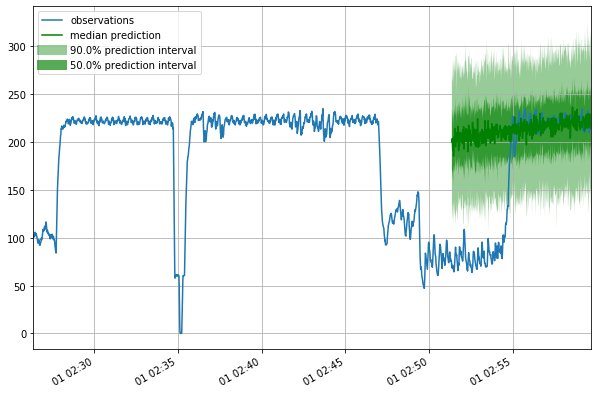

In [11]:
ts_entry = tss[7]
forecast_entry = forecast[7]
plot_prob_forecasts(ts_entry, forecast_entry) 

In [12]:
# test all 
#run_prophet_nonan(-1, 50, '1D')

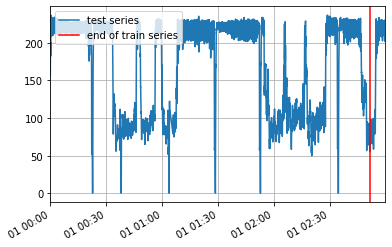

In [13]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_ds))
train_series = to_pandas(entry)
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.dropna().plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [14]:
np.min(test_series.to_numpy())

/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


nan

In [15]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 500
Recommended prediction horizon: 500
Frequency of the time series: 1s


In [16]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [202.6409194  201.21480495 192.21147613 194.22862198 199.26674688
 203.40506547 186.14428067 203.75539907 205.46478366 205.36931869
 197.35452511 206.12769964 213.4798851  197.38019638 204.99545704
 204.80726332 204.97367224 199.64950299 203.04957928 208.43726389
 208.72409002 202.16590398 215.5598285  199.71159264 200.91580326
 205.90245475 208.95270696 200.89261231 206.74162726 209.98829406
 200.28585668 200.67696224 208.53336065 204.35816777 195.87413984
 206.5796682  203.67079722 202.20802288 210.32777967 208.06169571
 203.36577605 194.25379252 211.00665732 195.79952109 199.57393678
 205.37863757 205.40997374 208.4400336  206.56141451 210.34779127
 212.2100535  210.62116283 202.94139438 209.88199091 200.6312752
 201.27617642 205.5725864  207.61788109 191.31355397 204.84878281
 220.38241525 199.7373865  212.85732863 209.44281289 208.45895546
 208.18500073 203.59093238 209.17624061 194.80265164 206.1613887
 204.43473247 201.68867575 204.11832329 199.711855

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

Individual metrics are aggregated only across time-steps.

### R-predictor

In [17]:
from gluonts.model.r_forecast import RForecastPredictor
est = RForecastPredictor(method_name='ets',freq= freq, prediction_length = prediction_length)
arima = RForecastPredictor(method_name='arima',freq= freq, prediction_length = prediction_length)

#train_ds, test_ds = make_dataset_nonan(1, prediction_length,freq)
#train_ds, test_ds = make_dataset(prediction_length,freq)

tss, forecast = evaluate_model(test_ds, est)

/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/gluonts/model/r_forecast/_predictor.py:191: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  + data["target"].shape[0]
Running evaluation: 100%|██████████| 33/33 [00:00<00:00, 71.91it/s]

{
    "MSE": 11165.014685055508,
    "abs_error": 1313382.124735693,
    "abs_target_sum": 2428020.197265625,
    "abs_target_mean": 153.7611862034535,
    "seasonal_error": 2.929936713693926,
    "MASE": 29.275472695441803,
    "sMAPE": 0.5948601062743109,
    "MSIS": 244.0209906684032,
    "QuantileLoss[0.1]": 924852.9005889257,
    "Coverage[0.1]": 0.06933041413814055,
    "QuantileLoss[0.5]": 1313382.124735693,
    "Coverage[0.5]": 0.6621222723530807,
    "QuantileLoss[0.9]": 990123.7085986618,
    "Coverage[0.9]": 0.9978446677572643,
    "RMSE": 105.66463308532097,
    "NRMSE": 0.6871996483267748,
    "ND": 0.5409271826547368,
    "wQuantileLoss[0.1]": 0.38090824023229775,
    "wQuantileLoss[0.5]": 0.5409271826547368,
    "wQuantileLoss[0.9]": 0.407790556978774,
    "mean_wQuantileLoss": 0.44320865995526953,
    "MAE_Coverage": 0.09687884199073483
}


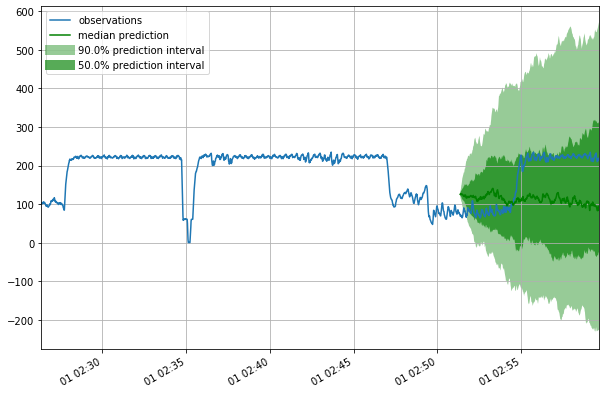

In [18]:
ts_entry = tss[7]
forecast_entry = forecast[7]
plot_prob_forecasts(ts_entry, forecast_entry)

In [19]:
#tss, forecast = evaluate_model(test_ds, arima)
ts_entry = tss[7]
forecast_entry = forecast[7]
#plot_prob_forecasts(ts_entry, forecast_entry)

### DeepAR

In [10]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
freq='1min'
prediction_length = 100
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length = 3*prediction_length,
    use_feat_static_cat=True,
    cardinality=cardinality,
    freq=freq,
    trainer=Trainer(ctx="gpu(2)", 
                    epochs=1, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=64
                   )
)

In [11]:
train_ds, test_ds, train_set, test_set = make_dataset_interpolate(prediction_length,'1min')
#train_ds, test_ds, train_set, test_set = make_dataset_interpolate(prediction_length,'1S')

carno:1, len:10791, nancount:184
carno:3, len:7918, nancount:72
carno:4, len:10797, nancount:249
carno:6, len:10791, nancount:201
carno:7, len:10806, nancount:279
carno:9, len:10787, nancount:88
carno:10, len:2868, nancount:46
carno:12, len:10782, nancount:85
carno:13, len:3557, nancount:46
carno:14, len:9993, nancount:171
carno:15, len:10793, nancount:193
carno:17, len:10799, nancount:525
carno:18, len:6851, nancount:66
carno:19, len:10789, nancount:176
carno:20, len:10785, nancount:207
carno:21, len:10799, nancount:176
carno:22, len:10789, nancount:384
carno:23, len:10824, nancount:200
carno:24, len:8246, nancount:789
carno:25, len:10816, nancount:210
carno:26, len:10798, nancount:259
carno:27, len:10787, nancount:194
carno:28, len:10789, nancount:203
carno:29, len:10790, nancount:187
carno:30, len:1969, nancount:46
carno:32, len:6069, nancount:957
carno:33, len:2394, nancount:323
carno:59, len:10785, nancount:199
carno:60, len:10817, nancount:213
carno:64, len:10820, nancount:192
ca

In [12]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 64/64 [01:53<00:00,  1.78s/it, avg_epoch_loss=4.63] 
INFO:root:Epoch[0] Elapsed time 113.886 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.630399
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 4.630399204790592 (occurred at epoch 0)
INFO:root:End model training


In [97]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [98]:
forecasts = list(forecast_it)


In [99]:
tss = list(ts_it)


AttributeError: 'datetime.datetime' object has no attribute 'value'

In [ ]:
forecast_entry

In [ ]:
ts_entry = tss[7]
forecast_entry = forecast[7]
plot_prob_forecasts(ts_entry, forecast_entry)

In [35]:
len(forecast)

33

In [ ]:
#entry = next(iter(forecast_it))
#train_series = to_pandas(entry)
entry = next(ts_it)
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [57]:
#entry = next(iter(forecast_it))
#train_series = to_pandas(entry)
entry = next(ts_it)
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

AttributeError: 'datetime.datetime' object has no attribute 'value'

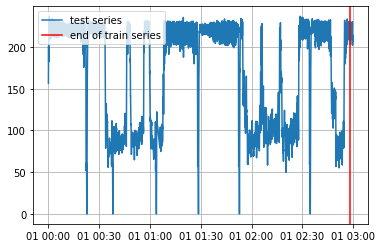

In [93]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_ds))
train_series = to_pandas(entry)
entry = next(iter(test_ds))
test_series = to_pandas(entry)
#test_series.plot()
plt.plot(test_series.index, test_series.values)
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [ ]:
#[np.sum(x['target'] == np.nan) for x in test_set]
[x['target'].shape for x in test_set]

In [94]:
test_series

2019-01-01 00:00:00    156.669998
2019-01-01 00:00:01    166.139999
2019-01-01 00:00:02    173.779999
2019-01-01 00:00:03    180.419998
2019-01-01 00:00:04    188.149994
2019-01-01 00:00:05    194.020004
2019-01-01 00:00:06    201.100006
2019-01-01 00:00:07    196.350006
2019-01-01 00:00:08    190.250000
2019-01-01 00:00:09    182.779999
2019-01-01 00:00:10    182.350006
2019-01-01 00:00:11    187.210007
2019-01-01 00:00:12    190.729996
2019-01-01 00:00:13    195.979996
2019-01-01 00:00:14    200.669998
2019-01-01 00:00:15    204.179993
2019-01-01 00:00:16    210.149994
2019-01-01 00:00:17    210.369995
2019-01-01 00:00:18    212.779999
2019-01-01 00:00:19    212.149994
2019-01-01 00:00:20    214.000000
2019-01-01 00:00:21    216.470001
2019-01-01 00:00:22    219.800003
2019-01-01 00:00:23    223.179993
2019-01-01 00:00:24    225.910004
2019-01-01 00:00:25    228.149994
2019-01-01 00:00:26    232.259995
2019-01-01 00:00:27    232.679993
2019-01-01 00:00:28    233.639999
2019-01-01 00: